In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pprint import pprint
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.iolib import SimpleTable
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt, het_white, het_arch, acorr_ljungbox
from statistics import *
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from scipy.optimize import curve_fit
from scipy.stats.stats import kurtosis, skew
from scipy.stats import boxcox
from IPython.core.display import display
from patsy import dmatrices
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from arch.univariate import ARX, ARCH, GARCH
import warnings
from datetime import datetime, timedelta
import seaborn as sns
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linewidth'] = .5
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 15

In [2]:
df = pd.read_csv('./data/factors/RTSI.csv', parse_dates=['Date'], index_col='Date', dayfirst=True)
series = df['2009-01':'2019'].Close
series = series.resample('14d').last()
series2020 = df['2020':].Close

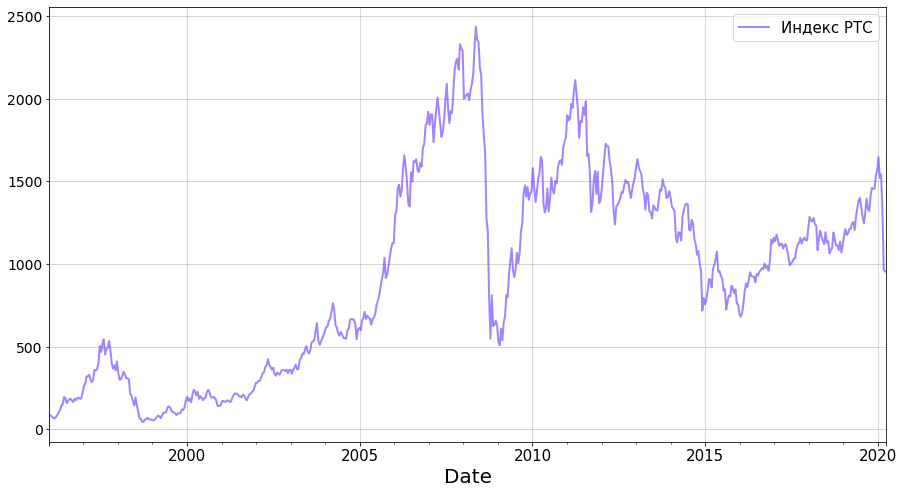

In [3]:
df.Close.resample('14d').last().plot(label='Индекс РТС', legend=True, linewidth=2, color='#63f9');

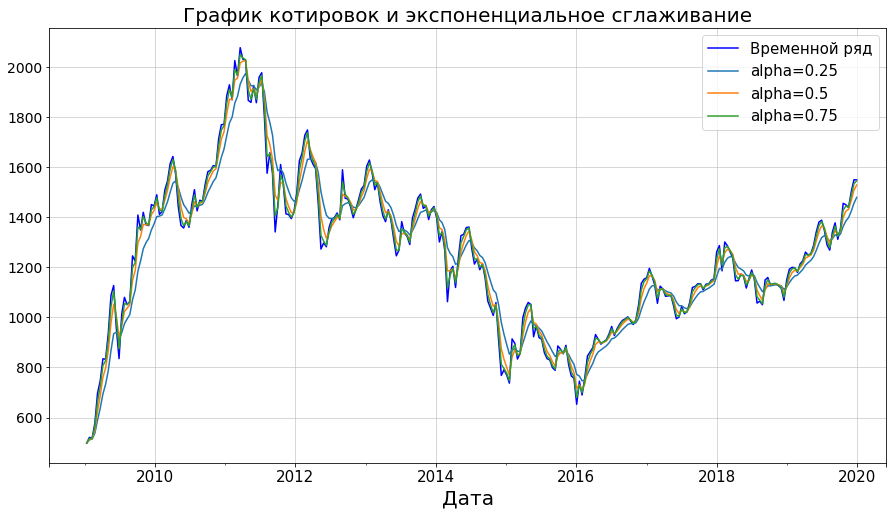

In [4]:
ax = series.plot(legend=True, color='blue', label='Временной ряд')
for alpha in [.25, .5, .75]:
    series.ewm(alpha=alpha).mean().plot(ax=ax, label=f'alpha={alpha}', legend=True)
ax.set_title('График котировок и экспоненциальное сглаживание')
ax.set_xlabel('Дата');
ax.set_xlim('2008-07', '2020-06')
del ax

### Тест Фуллера на стационарность ряда

In [5]:
fuller_test = adfuller(arimax.resid)
crit_value = fuller_test[4]

print(f'Т-статистика δ кф вспомогательного уравнения: {fuller_test[0]:.3f}')
print(f'p-value: {fuller_test[1]:.3f}')
print(f'Число наблюдений во вспомогательном уравнении: {fuller_test[3]}')
print(f'Критические значения T-статистики:')
print(f'  1%:  {crit_value["1%"]:.3f}')
print(f'  5%:  {crit_value["5%"]:.3f}')
print(f'  10%: {crit_value["10%"]:.3f}')

if fuller_test[0] > crit_value['1%']:
    print('Ряд нестационарен на 1%')
else:
    print('Ряд стационарен на 1%')

if fuller_test[0] > crit_value['5%']:
    print('Ряд нестационарен на 5%')
else:
    print('Ряд стационарен на 5%')
del fuller_test

NameError: name 'arimax' is not defined

In [ ]:
sm.tsa.seasonal_decompose(series.interpolate(), period=10).plot();

# Тренд 1 + ARMA на остатках

# Составление тренда 

In [ ]:
series.plot()

In [ ]:
pf = PolynomialFeatures(degree=4)
xp = pf.fit_transform(np.arange(1, series.size+1)[:, np.newaxis])
series_trend_fitted_model = sm.OLS(series, xp).fit()

# plt.title('Данные и Тренд (Полиномиальный, 4 степени)')
plt.plot(series, label='Индекс РТС')

# Значения линии тренда
# Вместо .fittedvalues можно .predict(xp)
series_trend = series_trend_fitted_model.fittedvalues
series_remains = series_trend_fitted_model.resid
series_remains_exog = series_trend_fitted_model.model.exog

plt.plot(series_trend, label='Трендовая линия индекса РТС');
plt.legend()
plt.show()
display(series_trend_fitted_model.summary())


In [ ]:
series_remains.plot(label='Остатки трендовой линии', legend=True);

In [ ]:
# fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
plot_acf(series_remains)
plot_pacf(series_remains);

In [ ]:
# Лучшие pdq - 4, 0, 4
model = ARIMA(series_remains, order=(4, 0, 4))
arima_by_series_remains = model.fit()
display(arima_by_series_remains.summary())

del model

In [ ]:
plot_acf(arima_by_series_remains.resid, title='Автокорреляция остатков ARIMA на series - trend(4)');

In [ ]:
plt.plot(series, label='Индекс РТС');
plt.plot(series_trend + arima_by_series_remains.fittedvalues, label='Тренд + ARMA (4, 4)');
# plt.title('RTSI; Тренд + ARIMA на остатках от series - trend(4)')
plt.legend()
plt.show()

In [ ]:
arima_by_series_remains.resid.plot(label='Остатки модели тренд + ARMA(4, 4)', legend=True);

# Проверка предпосылок регрессионного анализа (остатков от тренда)
#### - Нулевая средняя величина
#### - Остатки подчиняются нормальному распределению
#### - Случайный характер остатков
#### - Гомоскедастичность
#### - Отсутствие автокорреляции
#### (Некоторые тесты выводятся выше при составлении тренда (Дарбин-Уотсон)

## Нулевая средняя величина

In [ ]:
print(f'Средняя величина остатков: {arimax.resid.mean():.4f}')

## 2)Остатки подчиняются нормальному распределению 

### На уровне значимости 0.05, нулевая гипотеза о нормальности распределения принимается

In [ ]:
display(SimpleTable(
    np.array([sm.stats.stattools.jarque_bera(series_remains)]),
     ['JB', 'p-value', 'skew', 'kurtosis']
))
# Гипотеза Н0 - о нормальном распределении остатков
# Чем ближе распределение ошибок к нормальному, тем меньше статистика Харке—Бера отличается от нуля.
#При достаточно большом значении статистики p-value будет мало,
#и тогда будет основание отвергнуть нулевую гипотезу (статистика попала в «хвост» распределения). 

### Критерии ассиметрии и эксцесса, и РС

In [ ]:
variable = arimax.resid

kurt = kurtosis(variable)
n = variable.size
kurt_critical = 5*(24*n*(n-2)*(n-3)/(n+1)**2/(n+3)/(n+4))**.5
sk = skew(variable)
sk_critical = 3*(6*(n-1)/(n+1)/(n+3))**.5

if kurt < kurt_critical:
    print(f'Эксцесс {kurt:.4f} меньше критического {kurt_critical:.4f}')
else:
    print(f'Эксцесс {kurt:.4f} больше, либо равен критическому {kurt_critical:.4f}')

if sk < sk_critical:
    print(f'Ассиметрия {sk:.4f} меньше критического {sk_critical:.4f}')
else:
    print(f'Ассиметрия {sk:.4f} больше, либо равна критической {sk_critical:.4f}')
    
rem = variable
# Полученное значение сравнивается с табличными 
# С вероятностью ошибки-0.05 и длиной выборки-100 РС критерий должен быть в диапазон(4.31; 5.9)
rc = (rem.max() - rem.min()) / ((rem**2).sum()/len(rem)-1)**.5
print(f'РС критерий: {rc:.4f}')

if kurt < kurt_critical and sk < sk_critical and 4.3 < rc < 5.9:
    print('Вывод: Остатки распределены нормально')
else:
    print('Вывод: Остатки не распределены нормально')

## 3)Случайный характер остатков 

In [ ]:
fuller_test = adfuller(series_remains)
if fuller_test[0] > fuller_test[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')
del fuller_test
#H0 - наличие единичного корня т.е. нестационарность ряда
# Если p-value (второе значение теста) больше критического (0.05), то мы не можем отвергнуть нулевую гипотезу
# + проверяем значение самого теста. Если значение > критического от 5%, то ряд нестационарен.

## 4)Гомоскедастичность

In [ ]:
bp_test = het_breuschpagan(series_remains, series_remains_exog)
labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels, bp_test)))
# H0 - наличие гомоскедастичности. Если оба p-value меньше 0.05 - гетероскедастичность

In [ ]:
het_goldfeldquandt(series_remains, series_remains_exog, store=True)
# H0 - о равенстве дисперсий в двух подвыборках (гомоскедастичность)
# Смотрим на второе число (p-value) - p-value гипотезы что дисперсии отличаются. Если большое, то гетероскедастичность

### Тест Уайта

### F-критическое ищется по таблице F(0.01; 13, 120) = 3.255

### 5.94 > F критическое => уравнение значимое => гетероскедастичность

### Если последнее число(значимость F) < 0.05 => гетероскедастичность

In [ ]:
#1 вариант - использует дисперсии
white_test = het_white(series_remains, series_remains_exog)
labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels, white_test)))
# Тест аналогичен с бройшем паганом

### Тест Уайта вручную (другой вариант теста)

### При гетероскедастичности все полученные члены будут значимы и p-value>0.05

In [ ]:
tmp = series_remains.to_frame()
tmp['t'] = np.arange(tmp.size)
tmp['t2'] = tmp.t ** 2
tmp['t3'] = tmp.t ** 3
tmp['t4'] = tmp.t2 ** 2
tmp['t22'] = tmp.t2.copy()
tmp['t44'] = tmp.t4.copy()
tmp['t6'] = tmp.t3 ** 2
tmp['t8'] = tmp.t4 ** 2

tmp['a'] = tmp.t3.copy()
tmp['b'] = tmp.t4.copy()
tmp['c'] = tmp.t4 * tmp.t
tmp['d'] = tmp.t4 * tmp.t
tmp['e'] = tmp.t3 ** 2
tmp['f'] = tmp.t3 * tmp.t4
tmp['remains'] = series_remains ** 2

In [ ]:
f = smf.ols('remains ~ (t + t2 + t3 + t4 + t22 + t44 + t6 + t8 + a + b + c + d + e + f)', data=tmp).fit()
display(f.summary())
del tmp

### Тест парка на гомоскедастичность

### Гетероскедастичность если полученные уравнение по F-критерию значимы и значимый КФ при ln фактора

In [ ]:
tmp = series.to_frame()
tmp['t'] = np.log(np.arange(1, series.size+1))
tmp['t2'] = np.log(np.arange(1, series.size+1)**2)
tmp['t3'] = np.log(np.arange(1, series.size+1)**3)
tmp['t4'] = np.log(np.arange(1, series.size+1)**4)
tmp['Close2'] = np.log(series_remains ** 2)
tmp

In [ ]:
smf.ols('Close2 ~ t', data=tmp).fit().summary()

In [ ]:
smf.ols('Close2 ~ t2', data=tmp).fit().summary()

In [ ]:
smf.ols('Close2 ~ t3', data=tmp).fit().summary()

## 5)Проверка автокорр.

### Сравниваем эту T-статистику КФ автокорр. с T-табличным 
### (если |Tрасч|>Tтабл, то отклоняем H0 о незначимости коэф)

In [ ]:
plot_acf(series_remains);

In [ ]:
_kf = acf(series_remains, fft=False)[1]
t = (((_kf**2) * (series.size-2)) / (1-_kf**2))**.5

In [ ]:
print(f'Durbin-Watson = {durbin_watson(arimax.resid):.3f}')

In [ ]:
#Смотрим на зону, в которую попадает это число. (Если меньше примерно 1.5, то положительная автокорреляция)
durbin_watson(series_remains)

# Проверка остатков после (trend + Arima) 

In [ ]:
q_test = acf(arima_by_series_remains.resid, qstat=True, fft=False)
q_df = pd.DataFrame({'Q-stat': q_test[1], 'p-value': q_test[2]})
q_df['Q-stat'].plot()
plt.show()
q_df['p-value'].plot();
del q_test, q_df

In [ ]:
acorr_ljungbox(arima_by_series_remains.resid, return_df=True)
# H0 - данные являются "белым шумом"
# Также можно сверить Q статистику с таблицей распределения ХИ-КВАДРАТ

### Остатки полученные после тренд + ARIMA по критерию бокса-льюинга являются белым шумом (поскольку все p-value до 40 лага >0.05)

### Прогноз тренд (1) + ARMA (4, 4)

In [ ]:
_ = []
for i in range(1, 300):
    _.append(5.06432082e+02 + 4.68925631e+01*i - 5.84355075e-01*(i**2) + 2.49624085e-03*(i**3) -3.45926525e-06*(i**4))

In [ ]:
series2020['2020-01-10':'2020-03-06'].plot(marker='h', markersize=10, label='Индекс РТС')
(arima_by_series_remains.predict('2020', '2020-03') + _[287:292]).plot(marker='h', markersize=10, label='Прогноз (5 периодов)')
plt.legend()
plt.show();

In [ ]:
plt.plot(series2020[series2020.index.isin(['2020-01-13', '2020-01-27', '2020-02-10', '2020-02-21', '2020-03-06'])].to_numpy())
plt.plot((arima_by_series_remains.predict('2020', '2020-03') + _[287:292]).to_numpy());

In [ ]:
r2_score(
    series2020[series2020.index.isin(['2020-01-13', '2020-01-27', '2020-02-10', '2020-02-21', '2020-03-06'])].to_numpy(),
    (arima_by_series_remains.predict('2020', '2020-03') + _[287:292])
)

## ARIMAX с факторами из регрессионного анализа

In [8]:
factors_dir = os.path.join('data', 'factors')

def read_csv(*args, **kwargs):
    kwargs.setdefault('parse_dates', ['Date'])
    kwargs.setdefault('index_col', 'Date')
    res = pd.read_csv(*args, **kwargs)
    if res.size < 50:
        res = res.resample('1y').last()
    elif res.size < 600:
        res = res.resample('1m').last()
    else:
        res = res.append(res.resample('1m').last())
    return res


# Создание series'ов и dataframe'ов
factors_csv = os.listdir(factors_dir)
for csv_file in factors_csv:
    if csv_file.startswith('.') or not csv_file.endswith('.csv'):
        continue
    var_name = os.path.splitext(csv_file)[0].lower()
    df_name = f'{var_name}_df'
    series_name = f'{var_name}_series'
    globals()[df_name] = read_csv(os.path.join(factors_dir, csv_file))
    globals()[series_name] = globals()[df_name].Close.resample('1d').last().dropna()
    
all_df = pd.DataFrame({
    # Индекс РТС
    'RTSI': rtsi_series,
    # Индекс S&P 500
    'SP500': sp500_series,
    # FTSE - Англия
    'FTSE': ftse_series,
    # DAX - Германия
    'DAX': dax_series,
    # SSE - Китай
    'SSE': sse_series,
    # Нефть Brent
    'Brent': brent_series,
    # USD/RUB
    'USD': usd_series,
    # Темпы роста ВВП РФ
    # 'GDP': gdp_series,
    # Золото
    'Gold': gold_series,
    # Уровень безработицы в РФ
    'Unemployment': unemployment_series,
    # Индекс потребительских цен
    # 'CPI': cpi_series,
    # Индекс потребительских цен погодично
    # 'CPI_year': cpi_year_series,
    # Индекс потребительских цен относительно 2000 года
    # 'CPI2000': cpi2000_series,
    # Индекс потребительских цен относительно 1996 года
    # 'CPI1996': cpi1996_series,
    # Ставки по межбанковским кредитам
    'InterbankRate': interbank_rate_series,
    # Доходность 6 месячных облигаций США
    'USA6mBond': usa_6m_bond_series,
    # Инвестиции в основной капитал
    # 'capital_investment': capital_investment_series,
    # Внешняя торговля РФ
    'international_trade': international_trade_series,
    # Индекс производительности труда
    'labor_performance': labor_performance_series,
    # Индекс промышленного производства
    'industrial_production': industrial_production_series,
    # Ключевая ставка
    'key_rate': key_rate_series,
    # Остатки на корреспондентских счетах
    # 'correspondent_accounts': correspondent_accounts_series,
    # Остатки на корреспондентских счетах (средние скорректированные)
    'correspondent_accounts_mean_scorr': correspondent_accounts_mean_scorr_series,
    # Номинальная зарплата
    # 'nominal_salary': nominal_salary_series,
    # Скорректированная номинальная зарплата
    'nominal_salary_scorr': nominal_salary_scorr_series,
    # ВВП РФ в абсолютном значении
    # 'abs_gdp': abs_gdp_series,
    # Скорректированный ВВП РФ в абсолютном значении
    'abs_gdp_scorr': abs_gdp_scorr_series,
    # Скорректированные инвестиции в основной капитал
    'capital_investment_scorr': capital_investment_series
})

In [90]:
test_df2 = all_df['2009-01-11':'2019'].resample('14d').last().copy()
arimax = sm.tsa.statespace.SARIMAX(
    test_df2['RTSI'], order=(1,1,1), seasonal_order=(0,0,0,0), exog=test_df2[['Brent', 'SP500']]
).fit()
arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   RTSI   No. Observations:                  287
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1539.631
Date:                Sat, 09 May 2020   AIC                           3089.262
Time:                        01:39:14   BIC                           3107.542
Sample:                    01-11-2009   HQIC                          3096.589
                         - 12-29-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Brent          7.1991      0.827      8.707      0.000       5.579       8.820
SP500          0.4535      0.070      6.447      0.000       0.316       0.591
ar.L1          0.7169      0.551      1.302      0.193      -0.362       1.796
ma.L1         -0.7492      0.517     -1.449      0.147      -1.763       0.264
sigma2      2771.7338    193.463     14.327      0.000    2392.554    3150.914
===================================================================================
Ljung-Box (Q):                       92.27   Jarque-Bera (JB):                14.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

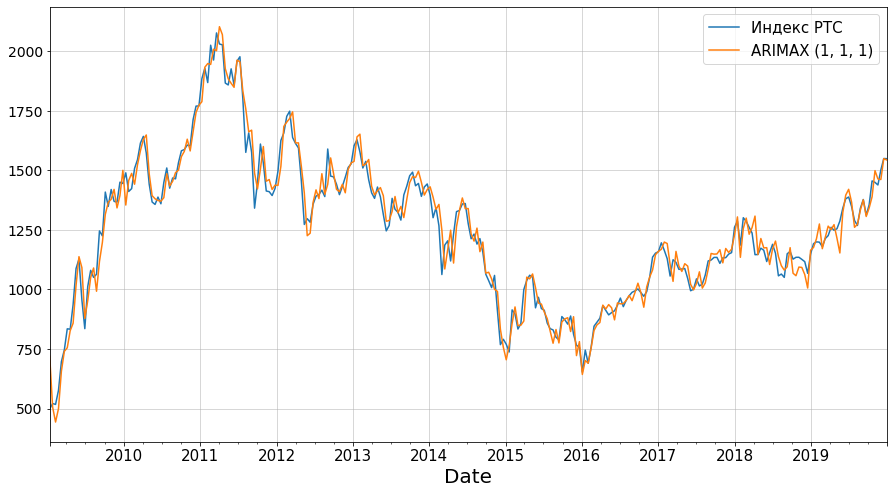

In [91]:
test_df2.RTSI.plot()
arimax.fittedvalues.plot()
plt.legend(['Индекс РТС', 'ARIMAX (1, 1, 1)'])

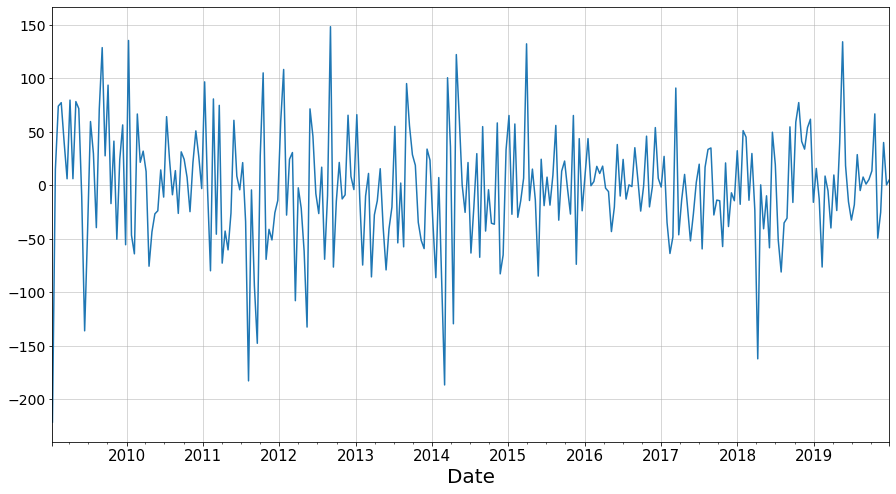

In [92]:
arimax.resid.plot()

In [96]:
linear_regression = sm.OLS(test_df2['RTSI'], test_df2[['Brent','SP500']]).fit()
linear_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   RTSI   R-squared (uncentered):                   0.974
Model:                            OLS   Adj. R-squared (uncentered):              0.974
Method:                 Least Squares   F-statistic:                              5394.
Date:                Sat, 09 May 2020   Prob (F-statistic):                   3.23e-227
Time:                        01:40:09   Log-Likelihood:                         -1937.1
No. Observations:                 287   AIC:                                      3878.
Df Residuals:                     285   BIC:                                      3885.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Brent         12.4484      0.291     42.754      0.000      11.875      13.021
SP500          0.1381      0.012     11.414      0.000       0.114       0.162
==============================================================================
Omnibus:                        4.794   Durbin-Watson:                   0.077
Prob(Omnibus):                  0.091   Jarque-Bera (JB):                3.689
Skew:                           0.158   Prob(JB):                        0.158
Kurtosis:                       2.544   Cond. No.                         47.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

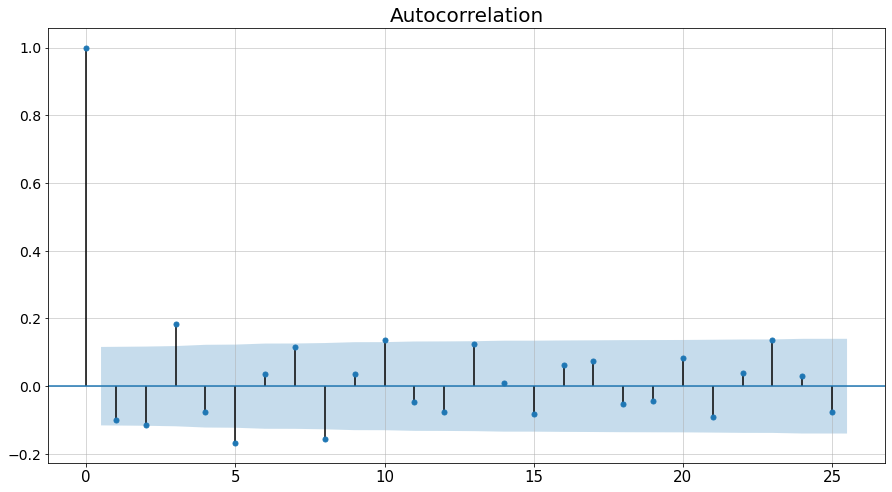

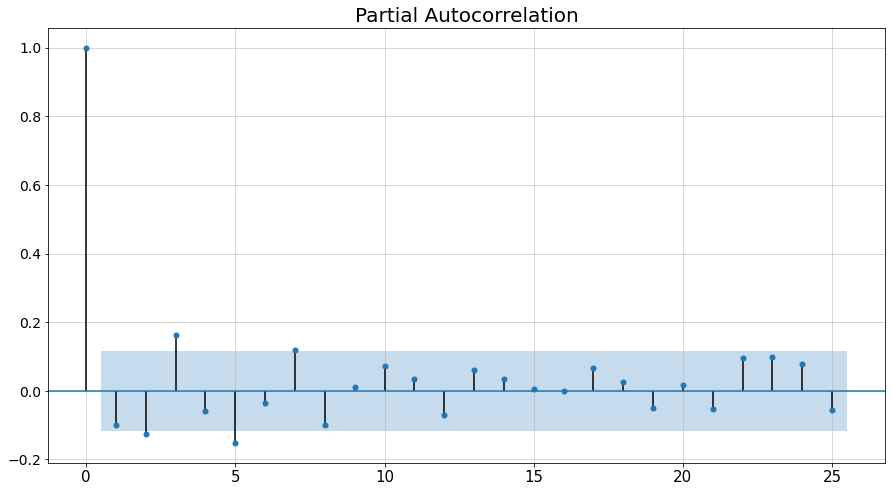

In [97]:
plot_acf(np.diff(linear_regression.resid))
plot_pacf(np.diff(linear_regression.resid))
plt.show()

In [109]:
arima_by_linear_regression_resid = ARIMA(linear_regression.resid, order=(1, 1, 1)).fit()

In [110]:
arima_by_linear_regression_resid.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  286
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1562.056
Method:                       css-mle   S.D. of innovations             56.984
Date:                Sat, 09 May 2020   AIC                           3132.112
Time:                        01:44:05   BIC                           3146.736
Sample:                    01-25-2009   HQIC                          3137.973
                         - 12-29-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6405      2.829      0.580      0.562      -3.905       7.186
ar.L1.D.y      0.2839      0.478      0.593      0.553      -0.654       1.222
ma.L1.D.y     -0.3994      0.459     -0.871      0.384      -1.298       0.499
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.5220           +0.0000j            3.5220            0.0000
MA.1            2.5036           +0.0000j            2.5036            0.0000
-----------------------------------------------------------------------------
"""

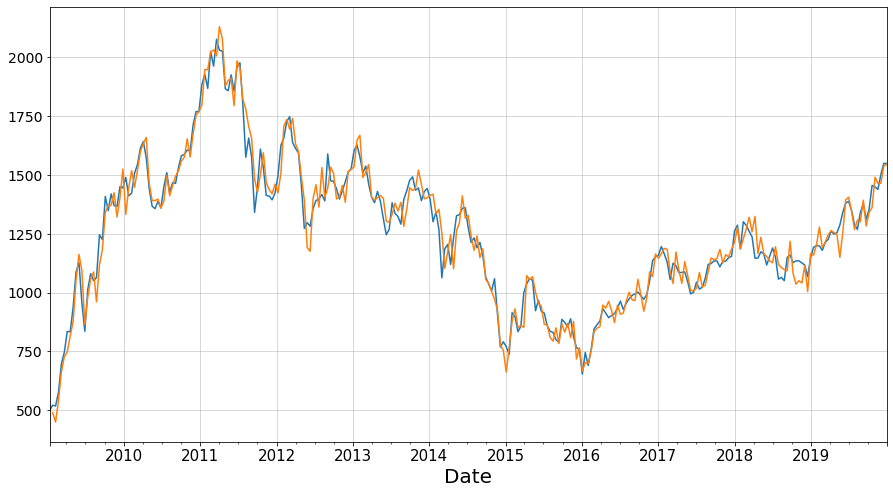

In [112]:
series.plot()
(linear_regression.fittedvalues + linear_regression.resid - arima_by_linear_regression_resid.resid).plot()

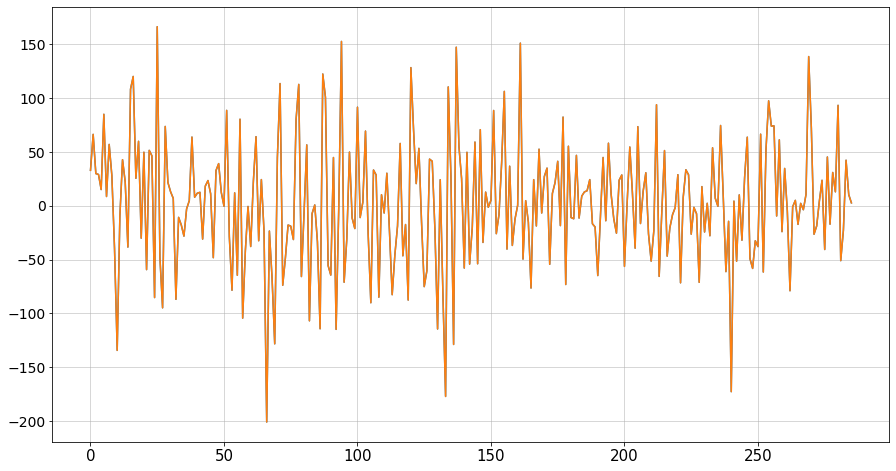

In [117]:
plt.plot((arima_by_linear_regression_resid.fittedvalues + arima_by_linear_regression_resid.resid).to_numpy())
plt.plot(np.diff(linear_regression.resid))

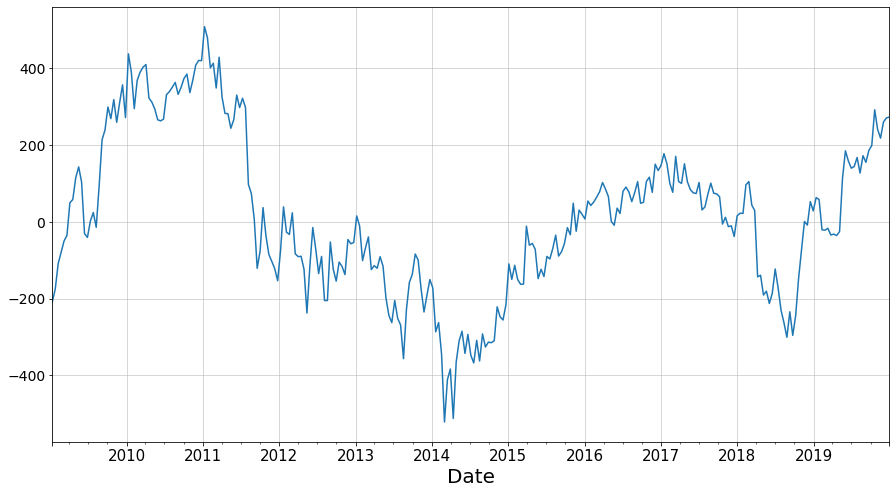

In [101]:
linear_regression.resid.plot()

### Прогноз

In [ ]:
arimax_predict = arimax.predict(
    '2020', '2020-02-15',
    exog=all_df[['Brent', 'SP500']]['2020':].resample('14d').last()[:5]
)
r2_score(
    rtsi_series['2020':].resample('14d').last()[:5], arimax_predict
)

In [ ]:
series2020['2020-01':'2020-03-06'].plot(marker='h', markersize=10, label='Индекс РТС')
arimax_predict.plot(marker='o', markersize=10)
plt.legend(['Индекс РТС', 'Прогноз (5 периодов)'])

# ARIMA на исходные данные 

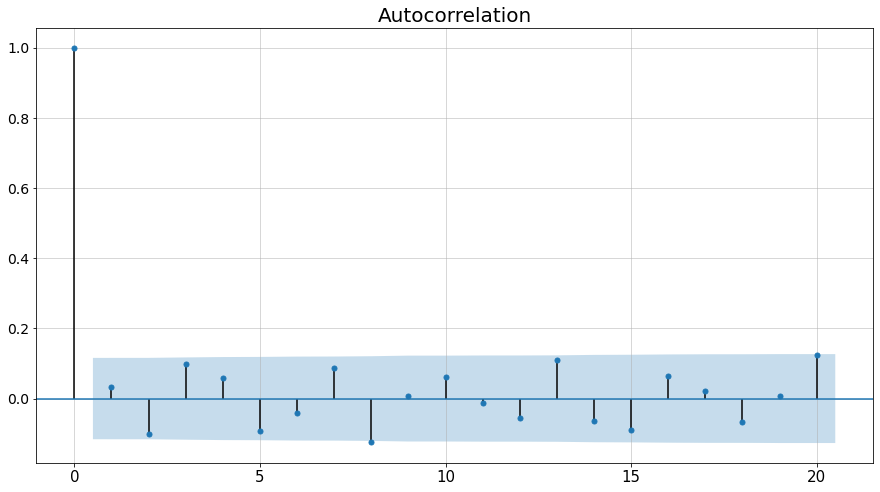

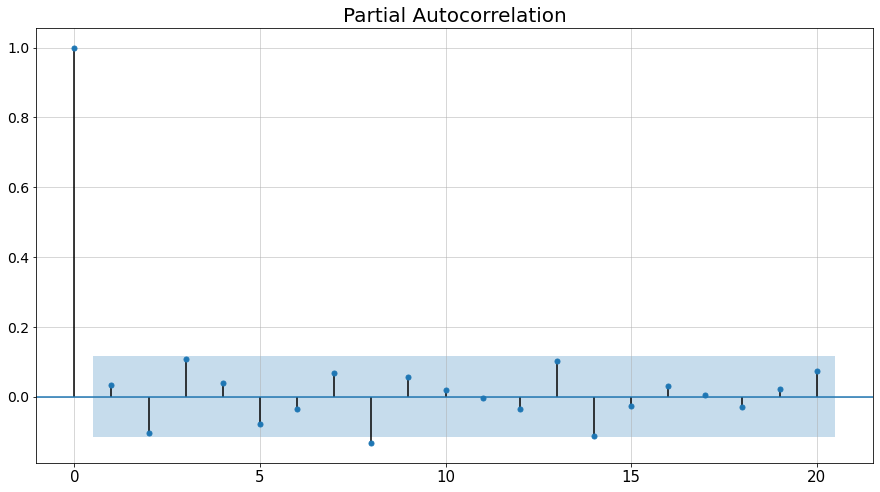

In [118]:
plot_acf(np.diff(series), lags=20)
plot_pacf(np.diff(series), lags=20);

In [ ]:
# r = Arima.find_optimal_model_by_order(series, [2,3,8], 1, [2,3,8], top=9)

In [ ]:
# for i in r:
#     print(i.order, i.aic)

In [119]:
arima_by_series = ARIMA(series, order=(2, 1, 2)).fit()

In [184]:
result_arima_by_series = pd.Series(
    data=(series[:-1].to_numpy() + arima_by_series.fittedvalues),
    index=series[1:].index
)

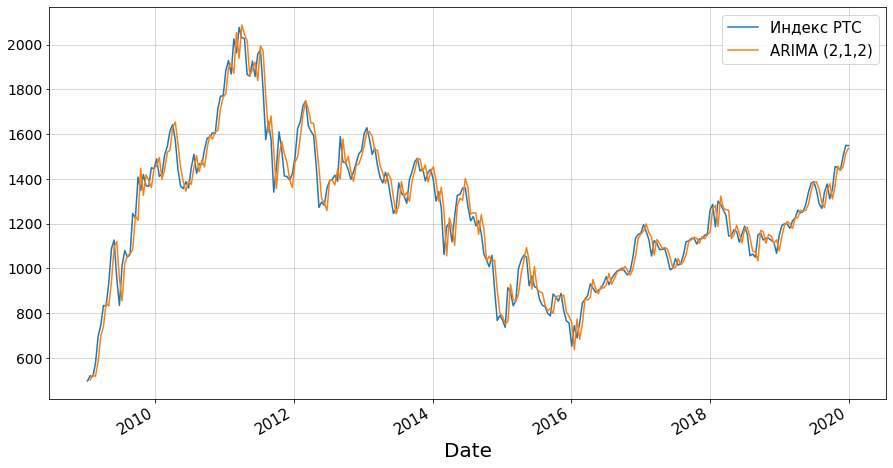

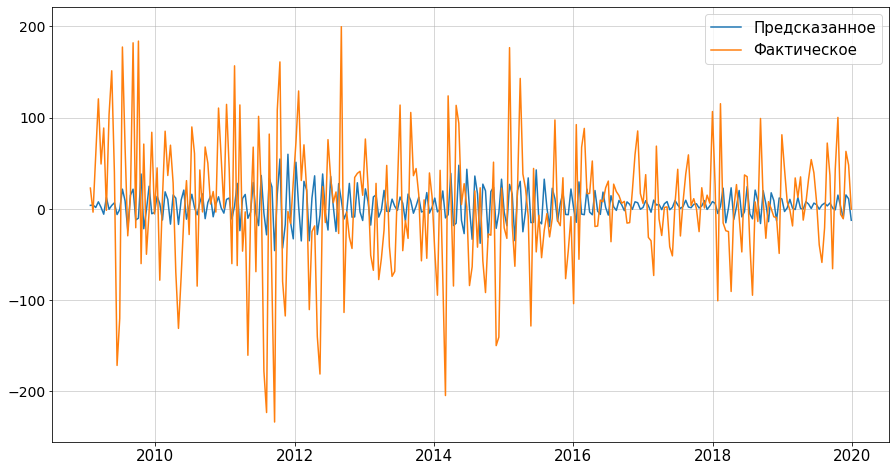

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  286
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1609.101
Method:                       css-mle   S.D. of innovations             67.107
Date:                Sat, 09 May 2020   AIC                           3230.202
Time:                        02:57:34   BIC                           3252.137
Sample:                    01-25-2009   HQIC                          3238.994
                         - 12-29-2019                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.7345      3.975      0.940      0.347      -4.056      11.525
ar.L1.D.Close    -0.7164      0.048    -14.974      0.000      -0.810      -0.623
ar.L2.D.Close    -0.9455      0.036    -26.037      0.000      -1.017      -0.874
ma.L1.D.Close     0.7642      0.062     12.244      0.000       0.642       0.887
ma.L2.D.Close     0.9019      0.062     14.590      0.000       0.781       1.023
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.3789           -0.9561j            1.0284           -0.3100
AR.2           -0.3789           +0.9561j            1.0284            0.3100
MA.1           -0.4237           -0.9640j            1.0530           -0.3159
MA.2           -0.4237           +0.9640j            1.0530            0.3159
-----------------------------------------------------------------------------
"""

In [190]:
plt.plot(series, label='Индекс РТС')
result_arima_by_series.plot(label='ARIMA (2,1,2)')
# plt.title(f'Арима {arima_by_series.k_ar}, {arima_by_series.k_diff}, {arima_by_series.k_ma} на данные')
plt.legend(fontsize=15)
plt.show()

# plt.plot(
#     arima_by_series.resid,
#     label=f'ARIMA ({arima_by_series.k_ar}, {arima_by_series.k_diff}, {arima_by_series.k_ma}) Residuals'
# )
# plt.plot(series - (series[:-1] + arima_by_series.fittedvalues.to_numpy()))
plt.plot(arima_by_series.fittedvalues)
plt.plot(series.diff())
plt.legend(['Предсказанное', 'Фактическое'])
plt.show();
arima_by_series.summary()

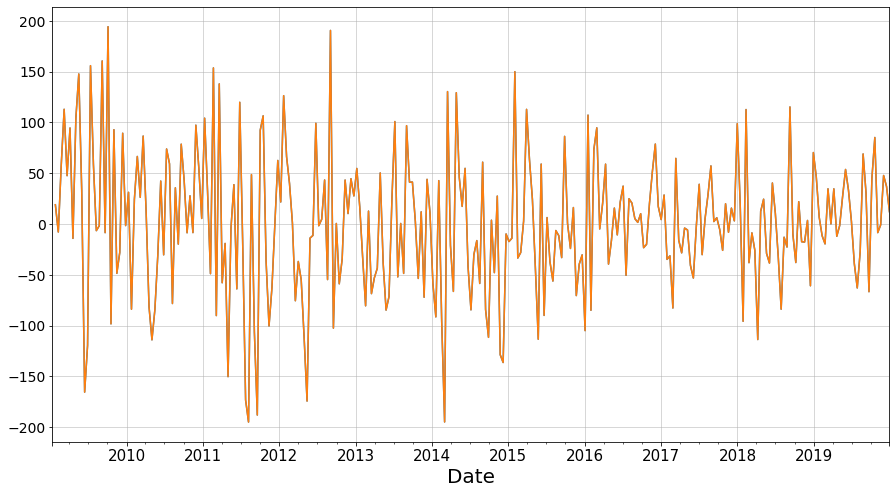

In [195]:
arima_by_series.resid.plot();
(series - result_arima_by_series).plot()

### Проверим остатки от этой ARIMA на белый шум

In [ ]:
plt.plot(arima_by_series.resid, label='Остатки аримы');

In [ ]:
q_test = acf(arima_by_series.resid, qstat=True, fft=False)
q_df = pd.DataFrame({'Q-stat': q_test[1], 'p-value': q_test[2]})
q_df['Q-stat'].plot()
plt.show()
q_df['p-value'].plot();
del q_test, q_df

In [ ]:
lb_df = acorr_ljungbox(arimax.resid, return_df=True, lags=20)
lb_df['Quantile χ2(0.05)'] = [3.8, 6.0, 7.8, 9.5, 11.1, 12.6, 14.1, 15.5, 16.9, 18.3, 19.7, 21.0, 22.4, 23.7, 25.0, 26.3, 27.6, 28.9, 30.1, 31.4]
lb_df

In [ ]:
lb_df[['lb_stat', 'Quantile χ2(0.05)']][:15].plot();

In [ ]:
acorr_ljungbox(arima_by_series.resid, return_df=True)
# H0 - данные являются "белым шумом"
# Также можно сверить Q статистику с таблицей распределения ХИ-КВАДРАТ

### Прогноз

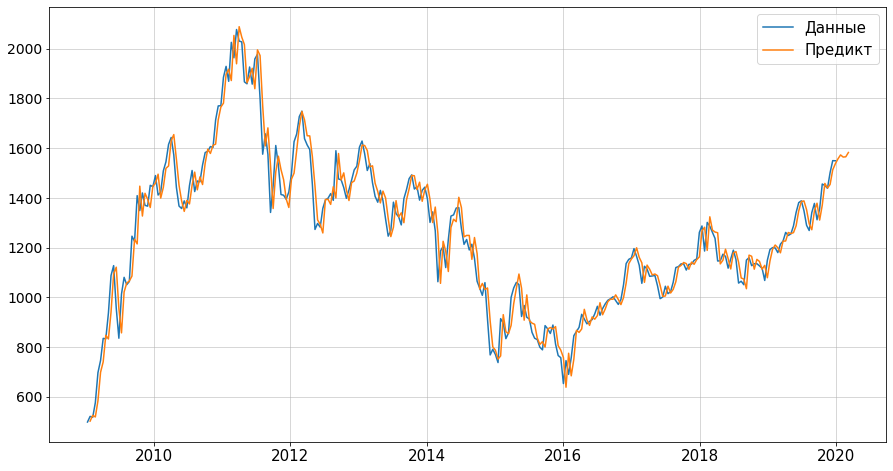

In [200]:
start = series[-1]
predicted = arima_by_series.predict('2020', '2020-03')
for i in range(len(predicted)):
    predicted[i] += start
    start = predicted[i]

plt.plot(series, label='Данные')
plt.plot((series - arima_by_series.resid).append(predicted), label='Предикт')
plt.legend()
plt.show();

In [ ]:
series2020 = df['2020':].Close
predicted2020 = (series - arima_by_series.resid).append(predicted)
predicted2020 = predicted2020['2020':]

In [ ]:
predicted.values

In [ ]:
plt.plot(
    series2020[series2020.index.isin(['2020-01-13', '2020-01-27', '2020-02-10', '2020-02-21', '2020-03-06'])].values)
plt.plot(
    predicted.values
);

In [ ]:
ser1 = series2020[series2020.index.isin(['2020-01-13', '2020-01-27', '2020-02-10', '2020-02-21', '2020-03-06'])]
ser2 = pd.Series(data=predicted.values, index=ser1.index)
r2_score(ser1.to_numpy(), ser2.to_numpy())

In [ ]:
plt.plot(series2020['2020-01-12':'2020-03-08'], label='Индекс РТС', marker='o')
plt.plot(predicted, label='Прогноз (5 периодов)', marker='s')
plt.plot(pd.Series(map(lambda x: x[0], arima_by_series.forecast(5)[2]), index=predicted.index))
plt.plot(pd.Series(map(lambda x: x[1], arima_by_series.forecast(5)[2]), index=predicted.index))
plt.fill_between(
    predicted.index, 
    pd.Series(map(lambda x: x[0], arima_by_series.forecast(5)[2]), index=predicted.index),
    pd.Series(map(lambda x: x[1], arima_by_series.forecast(5)[2]), index=predicted.index),
    color=((.3, .3, .3, .2), )
)
plt.xticks(rotation=20)
plt.legend();

## Тест CHOW

In [ ]:
rss_total = ((series - series_trend.mean())**2).sum()

In [ ]:
nom = (rss_total - rss1 - rss2 - rss3)/(3+3+3-4)
denom = (rss1 + rss2 + rss3)/(287-9)
nom/denom

In [ ]:
# Оптимальный '2011-10-31' / '2016-03-31'
#chow_test_result, split_point1, partial_series = \
#     Model(series['2011-06': ] ).cut_by_chow_test(arbitrarily=2, with_result=True)
#draw(partial_series)

In [ ]:
partial_series = PartialModel(series[:'2011-03'], series['2011-04':'2016-02'], series['2016-03':])
draw(partial_series)
plt.legend(['RTSI, I-part', 'RTSI, II-part ', 'RTSI, III-part'])
plt.show()

### 1-ый кусок

In [ ]:
partial_series.p1.plot()
partial_series.p1.polynomial_trend(3).plot()
plt.title('Первый кусок + полиномиальный тренд 3 степени')
plt.xlabel('')
plt.show()

partial_series.p1.polynomial_trend(3).fitted_model.resid.plot();
plt.title('Остатки от тренда')
plt.xlabel('')
plt.show()
display(partial_series.p1.polynomial_trend(3).fitted_model.summary())

In [ ]:
plot_acf(partial_series.p1)
plot_pacf(partial_series.p1);

In [ ]:
rss1 = ((partial_series.p1.polynomial_trend(3) - partial_series.p1.mean())**2).sum()

### 2-ой кусок 

In [ ]:
partial_series.p2.plot()
partial_series.p2.polynomial_trend(3).plot()
plt.title('Второй кусок + полиномиальный тренд 3 степени')
plt.xlabel('')
plt.show()

partial_series.p2.polynomial_trend(3).fitted_model.resid.plot();
plt.title('Остатки от тренда')
plt.xlabel('')
plt.show()
display(partial_series.p2.polynomial_trend(3).fitted_model.summary())

In [ ]:
plot_acf(partial_series.p2)
plot_pacf(partial_series.p2);

In [ ]:
rss2 = ((partial_series.p2.polynomial_trend(3) - partial_series.p2.mean())**2).sum()

### 3-ий кусок

In [ ]:
partial_series.p3.plot()
partial_series.p3.polynomial_trend(3).plot()
plt.title('Третий кусок + полиномиальный тренд 3 степени')
plt.xlabel('')
plt.show()

partial_series.p3.polynomial_trend(3).fitted_model.resid.plot();
plt.title('Остатки от тренда')
plt.xlabel('')
plt.show()
display(partial_series.p3.polynomial_trend(3).fitted_model.summary())

In [ ]:
rss3 = ((partial_series.p3.polynomial_trend(3) - partial_series.p3.mean())**2).sum()

In [ ]:
partial_series_p3_remains = partial_series.p3.polynomial_trend(3).fitted_model.resid

In [ ]:
plot_acf(partial_series_p3_remains)
plot_pacf(partial_series_p3_remains);

In [ ]:
order = (2, 0, 3)
# order = Arima.find_optimal_model_by_order(partial_series_p3_remains, (1, 2, 3), 0, (1, 2, 3, 4)).order
arima_by_partial_series_p3_remains = ARIMA(partial_series_p3_remains, order=order)
arima_by_partial_series_p3_remains_fitted_model = arima_by_partial_series_p3_remains.fit()

In [ ]:
arima_by_partial_series_p3_remains_fitted_model.summary()

In [ ]:
partial_series.p3.plot()
(partial_series.p3.polynomial_trend(3).series + arima_by_partial_series_p3_remains_fitted_model.fittedvalues).plot()

In [ ]:
mae(
    partial_series.p3,
    partial_series.p3.polynomial_trend(3).series + arima_by_partial_series_p3_remains_fitted_model.fittedvalues
)

### Выведем склеенный тренд и применим на все остатки ARIMA

In [ ]:
draw(partial_series);
partial_series_trend = (
    partial_series.p1.polynomial_trend(3)
    .append(partial_series.p2.polynomial_trend(3))
    .append(partial_series.p3.polynomial_trend(3))
)
partial_series_trend_remains = (series - partial_series_trend)
draw(partial_series_trend);

In [ ]:
draw(partial_series_trend_remains);
plt.legend(['Остатки трендовой кусочной модели'])
plt.show()

In [ ]:
plot_acf(partial_series_trend_remains)
plot_pacf(partial_series_trend_remains);

In [ ]:
# _ = Arima.find_optimal_model_by_order(partial_series_trend_remains, range(1, 5), 0, range(1, 5), top=16)

In [ ]:
arima_by_partial_series_trend_remains = ARIMA(partial_series_trend_remains, order=(4, 0, 4)).fit()
series.plot();
(partial_series_trend + arima_by_partial_series_trend_remains.fittedvalues).plot();
plt.legend(['Индекс РТС', 'Кусочный тренд + ARMA (4, 4)'])
plt.show()

In [ ]:
arima_by_partial_series_trend_remains.summary()

### Прогноз

In [ ]:
params = partial_series.p3.polynomial_trend(3).fitted_model.params
params

In [ ]:
__ = []
for i in range(106):
    __.append(params.const + params.x1*i + params.x2 * i**2 + params.x3*i**3)

In [ ]:
series2020['2020-01-10':'2020-03-06'].plot(marker='h', markersize=10, label='Индекс РТС')
plt.plot((arima_by_partial_series_trend_remains.predict('2020', '2020-03') + __[-5:]), marker='h', markersize=10)
plt.legend(['Индекс РТС', 'Прогноз (5 периодов)'])
plt.show()

In [ ]:
r2_score(
    (arima_by_partial_series_trend_remains.predict('2020', '2020-03') + __[-5:]),
    ser1
)

# Holt-Winters

In [ ]:
holt_winters = ExponentialSmoothing(series, seasonal_periods=9, trend='add', seasonal='mul', damped=True).fit()
holt_winters.summary()

In [ ]:
series.plot()
holt_winters.fittedvalues.plot();

In [ ]:
Model(series).aic(holt_winters.fittedvalues, 5)

In [ ]:
holt_winters.forecast(4)

### Оценивание точности

In [ ]:
def mape(other1, other):
    """ Критерий MAPE """
    return np.mean(np.abs((other1 - other) / other1)) * 100

def mae(other1, other):
    """ Критерий MAE """
    return np.mean(np.abs(other1 - other))

##### ARIMA (тренд + ARIMA на остатки)

In [ ]:
print(mape(series, series_trend + arima_by_series_remains.fittedvalues))
print(mae(series, series_trend + arima_by_series_remains.fittedvalues))
r2_score(series, series_trend + arima_by_series_remains.fittedvalues)

##### ARIMA на исходные данные

In [ ]:
print(mape(series, series - arima_by_series.resid))
print(mae(series, series - arima_by_series.resid))
r2_score(series.iloc[1:], (series - arima_by_series.resid).iloc[1:])

##### ARIMA с CHOW TEST

In [ ]:
print(mape(series, (partial_series_trend + arima_by_partial_series_trend_remains.fittedvalues)))
print(mae(series, (partial_series_trend + arima_by_partial_series_trend_remains.fittedvalues)))
r2_score(series, (partial_series_trend + arima_by_partial_series_trend_remains.fittedvalues))

##### ARIMAX с факторами из регрессионого анализа

In [ ]:
print(mape(test_df2.RTSI, arimax.fittedvalues))
print(mae(test_df2.RTSI, arimax.fittedvalues))
r2_score(test_df2.RTSI, arimax.fittedvalues)

##### Holt-Winters

In [ ]:
print(mape(series, holt_winters.fittedvalues))
print(mae(series, holt_winters.fittedvalues))
r2_score(series, holt_winters.fittedvalues)

# ARX-GARCH модель

In [ ]:
week_series = df['2009-01':'2019'].Close
week_series = week_series.resample('14d').last()

ar_by_week_series = ARX(week_series.to_numpy(), test_df2['Brent'].resample('14d').last().to_numpy()[:, np.newaxis], lags=1)
ar_by_week_series_fitted = ar_by_week_series.fit()
display(ar_by_week_series_fitted.summary())

argarch_by_week_series = ar_by_week_series
argarch_by_week_series.volatility = GARCH(p=1, q=1)
argarch_by_week_series_fitted = argarch_by_week_series.fit()
argarch_by_week_series_fitted.summary()

In [ ]:
week_series = df['2009':'2019'].Close
week_series = week_series.resample('14d').last()

ar_by_week_series = ARX(week_series.to_numpy(), lags=1)
ar_by_week_series_fitted = ar_by_week_series.fit()
display(ar_by_week_series_fitted.summary())

argarch_by_week_series = ar_by_week_series
argarch_by_week_series.volatility = GARCH(p=1, q=1)
argarch_by_week_series_fitted = argarch_by_week_series.fit()
argarch_by_week_series_fitted.summary()

In [ ]:
argarch_by_week_series_fitted.plot();

In [ ]:
week_series.plot()
(week_series - argarch_by_week_series_fitted.resid).plot();

In [ ]:
print(mape(week_series, (week_series - argarch_by_week_series_fitted.resid)))
mae(week_series, (week_series - argarch_by_week_series_fitted.resid))

In [ ]:
q = argarch_by_week_series_fitted.forecast(horizon=3, method='simulation', simulations=1_000).simulations.values

In [ ]:
_ = []
for i in q[-1]:
    _.extend(i)
    plt.plot(
        range(len(week_series) + len(i))[:],
        np.append(week_series.to_list(), _)[:]
    )
    _.clear()

In [ ]:
sns.boxplot(data=q[-1]);

# VAR + GARCH модель

In [ ]:
# week_series_changed = arch.data.sp500.load()['Adj Close'].pct_change().dropna() * 100
week_series_changed = df['2009':'2019'].Close
week_series_changed = week_series_changed.resample('13d').last()

week_series_changed = week_series_changed.pct_change().dropna()
am = arch_model(week_series_changed, vol='Garch', p=1, o=0, q=1, dist='Normal')
res = am.fit(disp='off', last_obs='2014-12-31')

forecasts = res.forecast(start='2015-1-1')
cond_mean = forecasts.mean['2015':]
cond_var = forecasts.variance['2015':]
q = am.distribution.ppf([0.01, 0.05])
print(q)

value_at_risk = cond_mean.values + np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(
    value_at_risk, columns=['1%', '5%'], index=cond_var.index)
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = week_series_changed['2015':].copy()
rets_2018.name = 'RTS return'
c = []


for idx in value_at_risk.index:
    if rets_2018[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2018[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
c = np.array(c, dtype='object')
labels = {
    '#BB0000': '1% Exceedence',
    '#BB00BB': '5% Exceedence',
    '#000000': 'No Exceedence'
}
markers = {'#BB0000': 'o', '#BB00BB': 's', '#000000': 'x'}
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        -rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
    )
ax.set_title('Parametric VaR')
leg = ax.legend(frameon=False, ncol=3)